# Generic

In [2]:
import yfinance as yf
import pandas as pd
def collect_ratios(tickers: list, ratios: list):
    rows = []

    for ticker in tickers:
        info = yf.Ticker(ticker).info
        row = [ticker] + [info.get(ratio, None) for ratio in ratios]
        rows.append(row)
    return pd.DataFrame(rows, columns=["Ticker"] + ratios)

objects = ["AEVA", "LAZR", "INVZ", "OUST"]
for o in objects:
    ticker = yf.Ticker(o)
    print(f"ticker {o}: ${ticker.info['marketCap']}")


ticker AEVA: $835110720
ticker LAZR: $14668649
ticker INVZ: $205902304
ticker OUST: $1359118208


In [3]:
import os
from dotenv import load_dotenv

load_dotenv()
key = os.getenv("datasource.alphavantage.secret")

In [4]:
from alpha_vantage.fundamentaldata import FundamentalData
objects = ["AEVA", "LAZR", "INVZ", "OUST"]
fd = FundamentalData(key=key, output_format='pandas')
for o in objects:
    df_earnings = fd.get_earnings_annual(o)[0].set_index('fiscalDateEnding')
    print(f"ticker {o}: {df_earnings}")


ticker AEVA:                  reportedEPS
fiscalDateEnding            
2025-09-30             -2.18
2024-12-31             -2.32
2023-12-31             -0.65
2022-12-31             -0.68
2021-12-31             -0.51
2020-12-31           -0.0185
2019-12-31              0.05


ValueError: Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints

In [5]:
collect_ratios(objects, ["sector", "industry", "debtToEquity"])

,Ticker,sector,industry,debtToEquity
0,AEVA,Technology,Software - Infrastructure,18.436
1,LAZR,Consumer Cyclical,Auto Parts,NaN
2,INVZ,Consumer Cyclical,Auto Parts,39.031
3,OUST,Technology,Electronic Components,6.425


In [6]:
objects = ["AEVA", "LAZR", "INVZ", "OUST"]
for o in objects:
    stock = yf.Ticker(o)
    print(f"{o}: {stock.earnings_estimate}")


AEVA:            avg   low  high  yearAgoEps  numberOfAnalysts  growth
period                                                          
0q     -0.4450 -0.47 -0.41     -0.4900                 4  0.0918
+1q    -0.4350 -0.46 -0.41     -0.4500                 2  0.0333
0y     -1.8175 -1.85 -1.77     -2.1700                 4  0.1624
+1y    -1.7975 -2.00 -1.56     -1.8175                 4  0.0110
LAZR:             avg      low     high  yearAgoEps  numberOfAnalysts  growth
period                                                                 
0q     -0.63922 -0.63946 -0.63897    -1.42000                 2  0.5498
+1q    -0.34000 -0.34000 -0.34000    -1.50000                 1  0.7733
0y     -4.21033 -4.28545 -4.13521    -9.24000                 2  0.5443
+1y    -2.23508 -3.52191 -0.94825    -4.21033                 2  0.4691
INVZ:             avg   low  high  yearAgoEps  numberOfAnalysts  growth
period                                                           
0q     -0.07667 -0.09 -0.06 

In [8]:
from pytrends.request import TrendReq

pytrend = TrendReq(hl='en-US', tz=360)
keywords = ["Luminar Technologies", "Ouster Inc",  "AEVA Technologies", "Innoviz Technologies"]
pytrend.build_payload(keywords, cat=0, timeframe='today 12-m', geo='', gprop='')
interest_over_time_df = pytrend.interest_over_time()
print(interest_over_time_df.head())
interest_over_time_df.to_csv('google_trends_data.csv')


            Luminar Technologies  Ouster Inc  AEVA Technologies  \
date                                                              
2024-12-22                    18           7                  0   
2024-12-29                    23           0                  0   
2025-01-05                    62           0                  0   
2025-01-12                   100           0                  0   
2025-01-19                    24           0                  0   

            Innoviz Technologies  isPartial  
date                                         
2024-12-22                     9      False  
2024-12-29                     5      False  
2025-01-05                    13      False  
2025-01-12                     8      False  
2025-01-19                    11      False  


/Users/tianyideng/gitrepos/investing-for-programmers/.venv/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [9]:
# to get rid of the column isPartial which can be added once in a while
iot_df = interest_over_time_df[["Luminar Technologies", "Ouster Inc", "AEVA Technologies", "Innoviz Technologies"]]

<Axes: xlabel='date'>

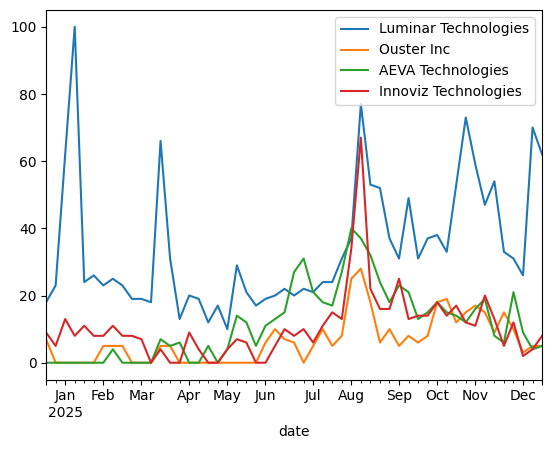

In [10]:
iot_df.plot()

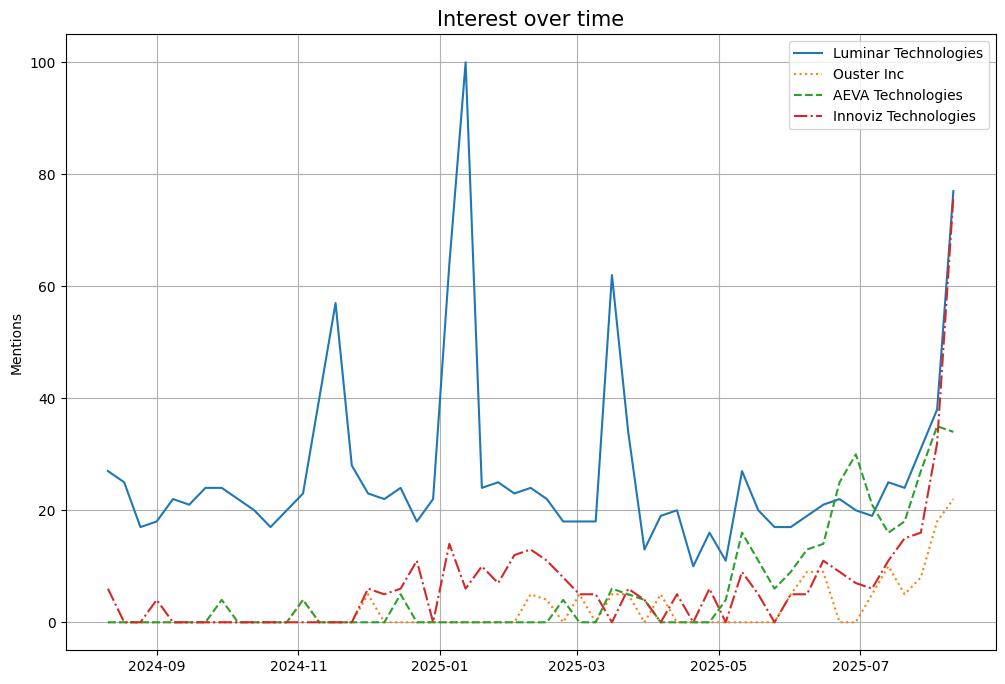

In [13]:
  # line style help with grey scale
import matplotlib.pyplot as plt
line_styles = ['-', ':', '--', '-.']
plt.figure(figsize=(12, 8))

plt.grid(True)
plt.ylabel("Mentions")
plt.title("Interest over time", fontsize=15)
for i, col in enumerate(iot_df.columns):
    style = line_styles[i % len(line_styles)]  # cycle styles

    plt.plot(
        iot_df.index,
        iot_df[col],
        linestyle=style,
        label=col
    )
    plt.legend(fontsize=10)

In [11]:
def collect_sentiments(ticker):
    import requests
    r = requests.get(f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&apikey={key}')
    return pd.DataFrame.from_dict(r.json()['feed'])


def summarize_sentiments(df, ticker):
    from collections import Counter

    ticker_sentiment = df['ticker_sentiment']
    label_string = ""
    score = 0
    for record in ticker_sentiment:
        if record[0]['ticker'] == ticker:
            if label_string != "":
                label_string += ","
            label_string += record[0]['ticker_sentiment_label']
            score += float(record[0]['ticker_sentiment_score'])

    print(score)
    word_count = Counter(label_string.split(","))
    word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count'])
    print(word_count_df)


In [12]:
collect_sentiments("AEVA")

,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,Aeva Technologies (NASDAQ:AEVA) Stock Price Do...,https://www.marketbeat.com/instant-alerts/aeva...,20251223T180903,[MarketBeat],Aeva Technologies (NASDAQ:AEVA) stock fell 5.5...,https://www.marketbeat.com/logos/aeva-technolo...,MarketBeat,General,MarketBeat,"[{'topic': 'earnings', 'relevance_score': '0.9...",-0.267456,Somewhat-Bearish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
1,Aeva to Showcase Passenger OEM Vehicle with Wi...,https://www.businesswire.com/news/home/2025121...,20251217T180916,[NULL],Aeva (Nasdaq: AEVA) will showcase a passenger ...,https://mms.businesswire.com/media/20251217340...,Business Wire,General,Business Wire,"[{'topic': 'technology', 'relevance_score': '1...",0.449204,Bullish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
2,Parkwood LLC Has $38.95 Million Position in Ae...,https://www.marketbeat.com/instant-alerts/fili...,20251212T130956,[MarketBeat],Parkwood LLC has reduced its stake in Aeva Tec...,https://www.marketbeat.com/logos/aeva-technolo...,MarketBeat,General,MarketBeat,"[{'topic': 'earnings', 'relevance_score': '0.9...",-0.329856,Somewhat-Bearish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
3,What AEVA's New Auto Contract Means for Its Gr...,https://www.theglobeandmail.com/investing/mark...,20251210T180934,[Zacks Investment Research],Aeva Technologies (AEVA) has secured a signifi...,https://staticx-tuner.zacks.com/images/article...,The Globe and Mail,General,The Globe and Mail,"[{'topic': 'technology', 'relevance_score': '0...",0.331877,Somewhat-Bullish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
4,What AEVA's New Auto Contract Means for Its Gr...,https://www.theglobeandmail.com/investing/mark...,20251210T092800,[Zacks Investment Research],Aeva Technologies (AEVA) has secured a signifi...,https://barchart-news-media-prod.aws.barchart....,The Globe and Mail,General,The Globe and Mail,"[{'topic': 'earnings', 'relevance_score': '0.9...",0.315285,Somewhat-Bullish,"[{'ticker': 'AEVA', 'relevance_score': '0.9575..."
5,Aeva (Nasdaq: AEVA) to present at 53rd Annual ...,https://www.stocktitan.net/news/AEVA/aeva-to-p...,20251209T210934,[NULL],"Aeva (Nasdaq: AEVA), a leader in next-generati...",NULL,Stock Titan,General,Stock Titan,"[{'topic': 'earnings', 'relevance_score': '0.8...",0.121700,Neutral,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
6,Aeva to Participate at the Annual Nasdaq Inves...,https://finance.yahoo.com/news/aeva-participat...,20251209T210920,[NULL],"Aeva (Nasdaq: AEVA), a leader in next-generati...",https://s.yimg.com/ny/api/res/1.2/dHE396X1M1w0...,Yahoo Finance,General,Yahoo Finance,"[{'topic': 'technology', 'relevance_score': '0...",0.168242,Somewhat-Bullish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
7,Aeva to Participate at the Annual Nasdaq Inves...,https://www.businesswire.com/news/home/2025120...,20251209T210741,[NULL],Aeva (Nasdaq: AEVA) announced its participatio...,https://mms.businesswire.com/media/20251209008...,Business Wire,General,Business Wire,"[{'topic': 'technology', 'relevance_score': '0...",0.397443,Bullish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
8,Aeva to Participate at the Annual Nasdaq Inves...,https://markets.financialcontent.com/stocks/ar...,20251209T160500,"[Aeva Technologies, Inc.]",Aeva (Nasdaq: AEVA) announced its participatio...,NULL,Markets Financial Content,General,Markets Financial Content,"[{'topic': 'technology', 'relevance_score': '0...",0.300596,Somewhat-Bullish,"[{'ticker': 'AEVA', 'relevance_score': '1.0000..."
9,JPMorgan Chase & Co. Has $13.24 Million Positi...,https://www.marketbeat.com/instant-alerts/fili...,20251208T210942,[MarketBeat],JPMorgan Chase & Co. significantly increased i...,https://www.marketbeat.com/logos/aeva-technolo...,MarketBeat,General,MarketBeat,"[{'topic': 'earnings', 'relevance_score': '0.9...",-0.22

In [ ]:
# LAZR

In [8]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot(ticker, start, end):
    data = yf.Ticker(ticker).history(start=start, end=end)
    df = pd.DataFrame(data).dropna()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Closing Price", linewidth=2)
    plt.title(ticker)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

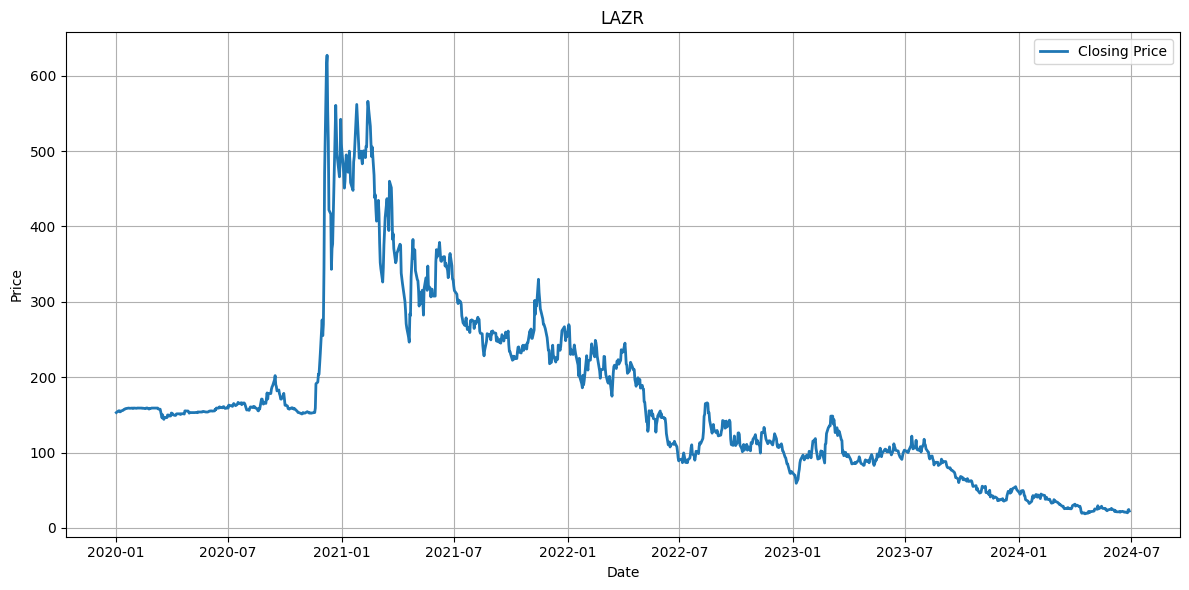

In [6]:
plot("LAZR", "2020-01-01", "2024-06-30")

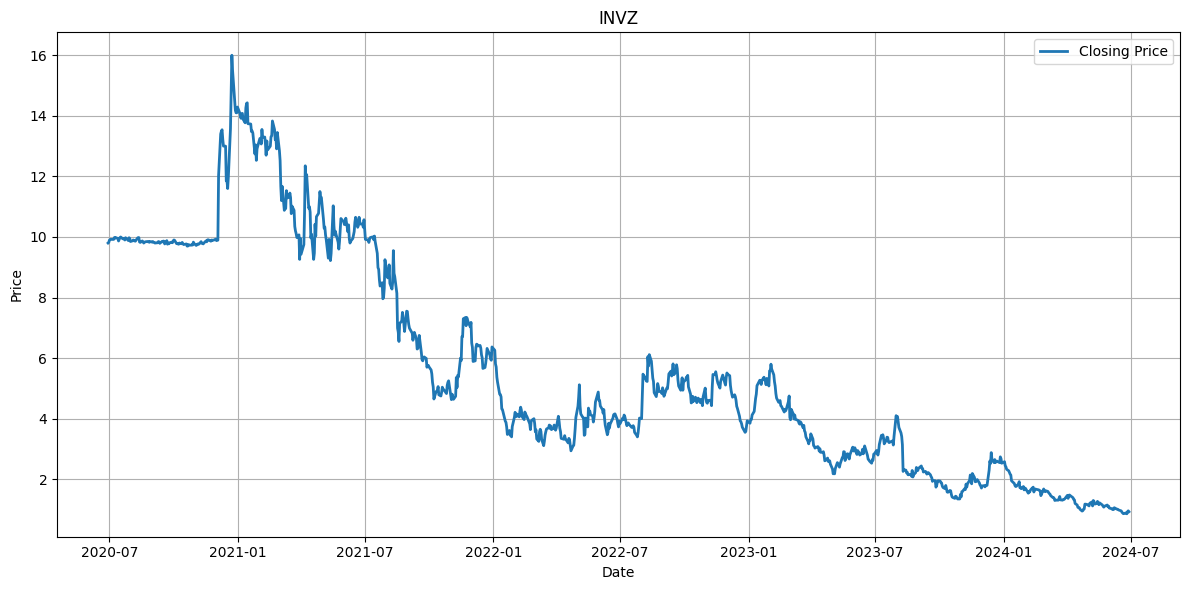

In [9]:
plot("INVZ", "2020-01-01", "2024-06-30")

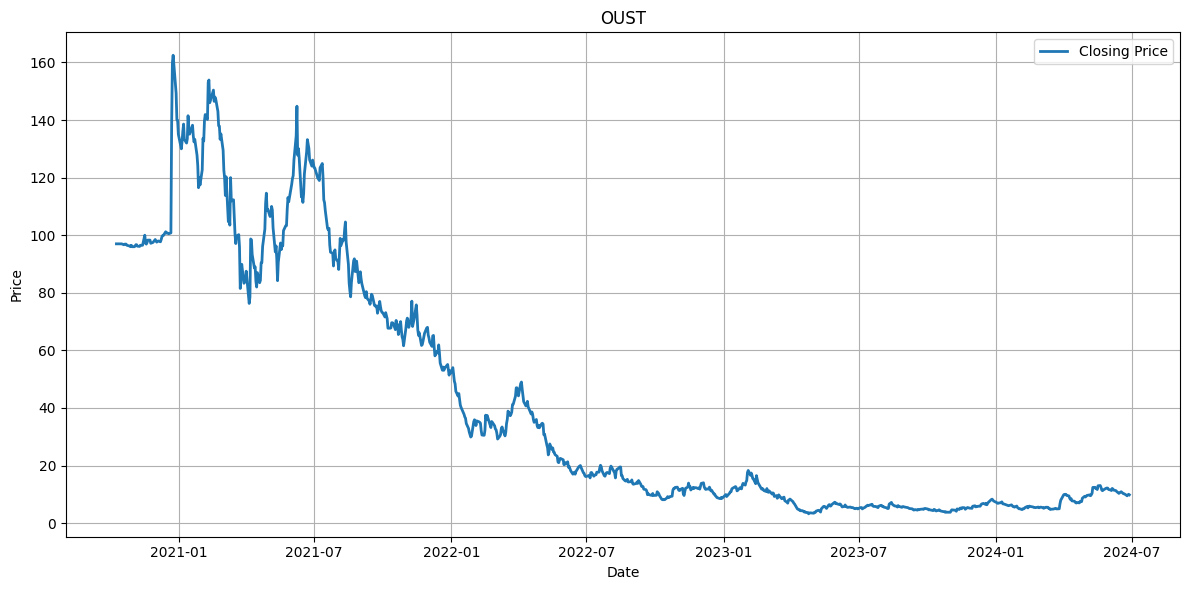

In [10]:
plot("OUST", "2020-01-01", "2024-06-30")

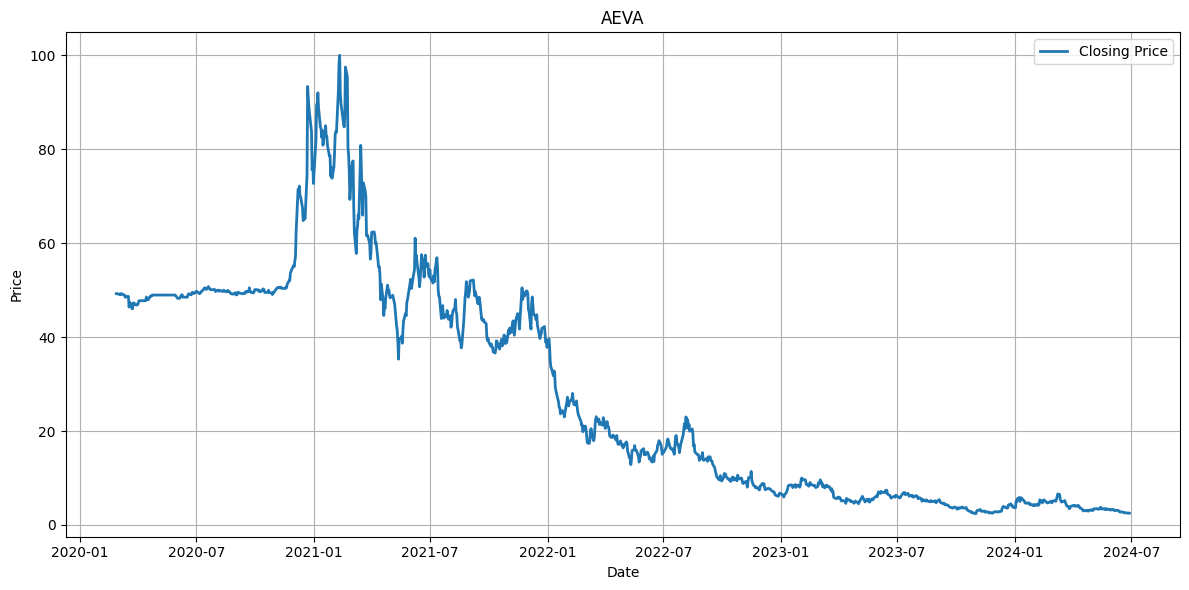

In [11]:
plot("AEVA", "2020-01-01", "2024-06-30")